In [8]:
# Number of data points to plot
num_points = 20

# Parameter ranges below
gc_actual = 0.1
# gc = 0 will lead to singular matrix during V_th computation, so don't set to 0.
gc_lo = 0.05
gc_hi = 0.5

ggap_actual = 1.0
ggap_lo = 0
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0
gsyn_hi = 1.5

C_actual = 0.015
# Only the last n_timesteps will be used for PCA analysis. This is to discard unstability
n_timesteps_to_analyze = 1000

In [9]:
import os
import pickle
# Load cached results
cached_result_file = 'cached_notebook_results/one_at_a_time.pkl'

if os.path.isfile(cached_result_file):
  print("Loading saved results from pickle file {}".format(cached_result_file))
  with open(cached_result_file, "rb") as f:
    gc_simulation_data, ggap_simulation_data, gsyn_simulation_data = pickle.load(f)
else:
  gc_simulation_data = []
  ggap_simulation_data = []
  gsyn_simulation_data = []
  
def save_results(gc_simulation_data, ggap_simulation_data, gsyn_simulation_data):
  with open(cached_result_file, "wb") as f:
    pickle.dump([gc_simulation_data, ggap_simulation_data, gsyn_simulation_data], f)

Loading saved results from pickle file cached_notebook_results/one_at_a_time.pkl


In [10]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

def gen_simulation_data(param_lo, param_hi, param_to_full_param_fcn, num_points):
  param_vals = []
  dom_amplitude_vals = []
  dom_amplitude_diff_raw_vals = []
  dom_amplitude_diff_scaled_vals = []
  dom_period_vals = []
  dimensionality_vals = []

  i = 0
  for param in np.linspace(param_lo, param_hi, num_points):
    i += 1
    start_time = time.time()
    param_vec = param_to_full_param_fcn(param)
    all_dynamics = simulate_until_stable(
      C = param_vec['C'], Gc = param_vec['Gc'], ggap = param_vec['ggap'], gsyn = param_vec['gsyn'])
    fwd_dynamics = all_dynamics[all_dynamics.shape[0] - n_timesteps_to_analyze:,:]
    elapsed_time = time.time() - start_time
    print("Iteration {0}/{1} for param {2:.4f} took {3:.2f}s".format(i, num_points, param, elapsed_time))

    n = fwd_dynamics.shape[0]
    X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
    pca = PCA()
    projected_X = pca.fit_transform(fwd_dynamics)
    dom_mode = projected_X[:,0]
    dom_amplitude = get_amplitude(dom_mode)
    dom_amplitude_diff_raw, dom_amplitude_diff_scaled = get_amplitude_differences(dom_mode)
    dom_period = get_period(dom_mode)
    eigen_vals = get_eigenvalues_from_pca(pca, n)
    dimensionality = get_dimensionality(eigen_vals)

    param_vals.append(param)
    dom_amplitude_vals.append(dom_amplitude)
    dom_amplitude_diff_raw_vals.append(dom_amplitude_diff_raw)
    dom_amplitude_diff_scaled_vals.append(dom_amplitude_diff_scaled)
    dom_period_vals.append(dom_period)
    dimensionality_vals.append(dimensionality)
  return (param_vals, dom_amplitude_vals, dom_amplitude_diff_raw_vals,
          dom_amplitude_diff_scaled_vals, dom_period_vals, dimensionality_vals)

def plot_simulation_results(param_vals, dom_amplitude_vals,
                            dom_amplitude_diff_raw_vals, dom_amplitude_diff_scaled_vals,
                            dom_period_vals, dimensionality_vals):
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
  ax = axes[0]
  ax.scatter(param_vals, dom_amplitude_vals)
  ax.set_title("Dom amplitude")
  ax = axes[1]
  ax.scatter(param_vals, dom_amplitude_diff_raw_vals)
  ax.set_title("Dom amplitude diff raw")
  ax = axes[2]
  ax.scatter(param_vals, dom_amplitude_diff_scaled_vals)
  ax.set_title("Dom amplitude diff scaled")
  ax = axes[3]
  ax.scatter(param_vals, dom_period_vals)
  ax.set_title("Dom period")
  ax = axes[4]
  ax.scatter(param_vals, dimensionality_vals)
  ax.set_title("Dimensionality")
  return fig

# Gc tweaks

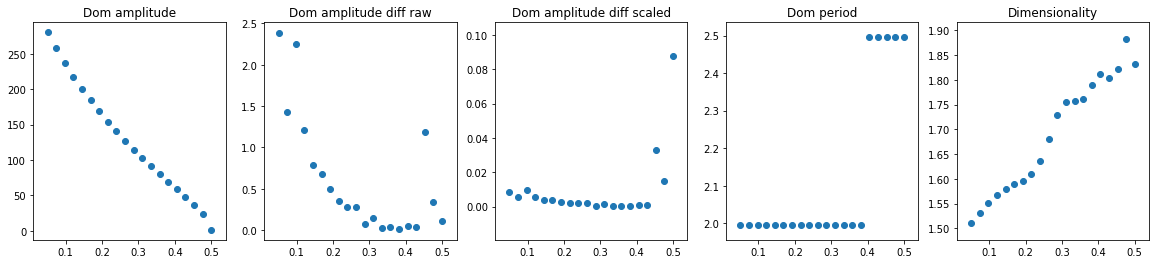

In [11]:
def gc_to_full_param(gc):
  return {
    'C': C_actual,
    'Gc': gc,
    'ggap': ggap_actual,
    'gsyn': gsyn_actual
  }

if len(gc_simulation_data) == 0:
  gc_simulation_data = gen_simulation_data(gc_lo, gc_hi, gc_to_full_param, num_points)
  save_results(gc_simulation_data, ggap_simulation_data, gsyn_simulation_data)
fig = plot_simulation_results(*gc_simulation_data)

# Ggap tweaks

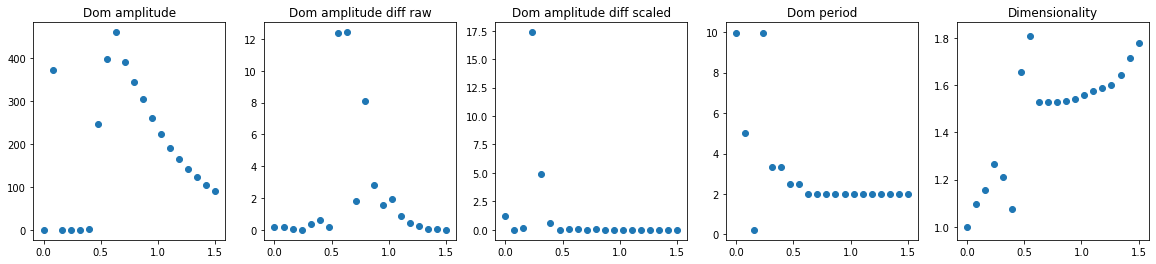

In [12]:
def ggap_to_full_param(ggap):
  return {
    'C': C_actual,
    'Gc': gc_actual,
    'ggap': ggap,
    'gsyn': gsyn_actual
  }

if len(ggap_simulation_data) == 0:
  ggap_simulation_data = gen_simulation_data(ggap_lo, ggap_hi, ggap_to_full_param, num_points)
  save_results(gc_simulation_data, ggap_simulation_data, gsyn_simulation_data)
fig = plot_simulation_results(*ggap_simulation_data)

# Gsyn tweaks

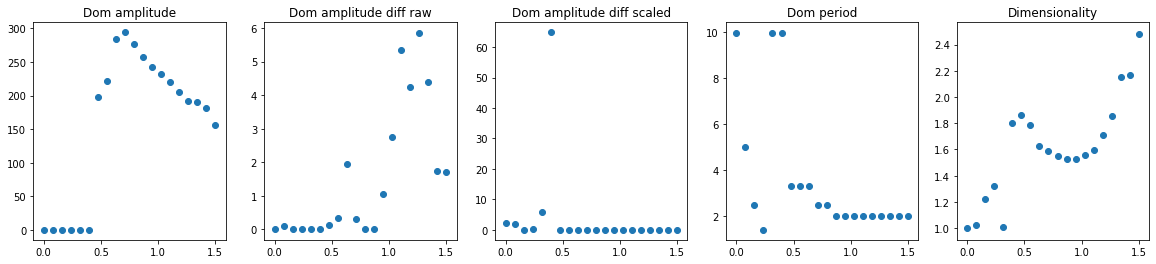

In [13]:
def gsyn_to_full_param(gsyn):
  return {
    'C': C_actual,
    'Gc': gc_actual,
    'ggap': ggap_actual,
    'gsyn': gsyn
  }


if len(gsyn_simulation_data) == 0:
  gsyn_simulation_data = gen_simulation_data(gsyn_lo, gsyn_hi, gsyn_to_full_param, num_points)
  save_results(gc_simulation_data, ggap_simulation_data, gsyn_simulation_data)
fig = plot_simulation_results(*gsyn_simulation_data)